In [6]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from matplotlib import pyplot as plt
import datetime
import pickle
from pretty_confusion_matrix import pp_matrix_from_data


In [2]:
DATA_PATH = "spectrogram_data.pkl"
# SAVE_MODEL_PATH = "model.h5"
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 32


def load_dataset(data_path):
    
#     with open(data_path, "r") as fp:
#         data = json.load(fp)
        
    with open(DATA_PATH, "rb") as f:
        data = pickle.load(f)
    
    X = np.array(data["spectrograms"])
    y = np.array(data["labels"])
    
    return X, y


def get_data_splits(data_path, test_size=0.1, test_validation=0.1):
    
    # load the dataset
    X, y = load_dataset(data_path)
    
    # create train/ validation/ test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,
                                                                    test_size=test_validation) # 0.1 of 0.9 -> 0.09
    
    # convert inputs from 2d to 3d arrays
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape, learning_rate):
    
    model = keras.Sequential()
    
    # layer 1
    model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape,
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding="same"))
    
    # layer 2
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding="same"))
    
    # layer 3
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding="same"))
    
    # layer 4
    model.add(keras.layers.Conv2D(32, (2, 2), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding="same"))
    
    model.add(keras.layers.Flatten())
    
    # layer 5
    model.add(keras.layers.Dense(8, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    
    # layer 6
    model.add(keras.layers.Dense(4, activation="softmax"))


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    model.summary()
    
    return model
    

def main():
    
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_data_splits(DATA_PATH)
    
    # build model
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # (segments, coefficients <13>, 1)
    model = build_model(input_shape, LEARNING_RATE)
    
    
    # train the model
    log_dir = "spectrogram_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_filepath = 'spectrogramtmp/checkpoint'

    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
    backup_callback = keras.callbacks.BackupAndRestore(backup_dir="spectrogramtmp/backup")
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath+"/{epoch:02d}-{val_accuracy:.2f}",
        monitor='val_accuracy',
        mode='max',
        save_freq='epoch',
        period=1,
        save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(X_validation, y_validation),
              callbacks=[tensorboard_callback, model_checkpoint_callback, backup_callback])
    
    # evaluate the model   
    print("evaling .......................")
    model.evaluate(X_test,y_test) 
    
    preds = model.predict(X_test)
    preds = np.array([np.argmax(x) for x in preds])

    str_labels = ['down', 'left', 'right', 'up']

    pp_matrix_from_data(preds, y_test, cmap='Blues_r', columns=str_labels)    
    
    return model, history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 255, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 42, 255, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 128, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 126, 32)       18464     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 126, 32)      128       
 hNormalization)                                                 
                                                        

INFO:tensorflow:Assets written to: tmp/checkpoint\01-0.42\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\01-0.42\assets


108/108 [==============================] - 58s 529ms/step - loss: 1.4261 - accuracy: 0.3344 - val_loss: 1.3008 - val_accuracy: 0.4178
Epoch 2/20
108/108 [==============================] - ETA: 0s - loss: 1.1478 - accuracy: 0.5163

INFO:tensorflow:Assets written to: tmp/checkpoint\02-0.71\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\02-0.71\assets


108/108 [==============================] - 60s 552ms/step - loss: 1.1478 - accuracy: 0.5163 - val_loss: 0.8769 - val_accuracy: 0.7102
Epoch 3/20
108/108 [==============================] - ETA: 0s - loss: 0.8829 - accuracy: 0.6612

INFO:tensorflow:Assets written to: tmp/checkpoint\03-0.77\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\03-0.77\assets


108/108 [==============================] - 62s 578ms/step - loss: 0.8829 - accuracy: 0.6612 - val_loss: 0.8281 - val_accuracy: 0.7702
Epoch 4/20
108/108 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.7106

INFO:tensorflow:Assets written to: tmp/checkpoint\04-0.80\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\04-0.80\assets


108/108 [==============================] - 63s 587ms/step - loss: 0.7219 - accuracy: 0.7106 - val_loss: 0.7173 - val_accuracy: 0.8016
Epoch 5/20
108/108 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7185

INFO:tensorflow:Assets written to: tmp/checkpoint\05-0.91\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\05-0.91\assets


108/108 [==============================] - 63s 585ms/step - loss: 0.6491 - accuracy: 0.7185 - val_loss: 0.3930 - val_accuracy: 0.9086
Epoch 6/20
108/108 [==============================] - 61s 561ms/step - loss: 0.5994 - accuracy: 0.7414 - val_loss: 0.3679 - val_accuracy: 0.9008
Epoch 7/20
108/108 [==============================] - 58s 537ms/step - loss: 0.5806 - accuracy: 0.7461 - val_loss: 0.6002 - val_accuracy: 0.8486
Epoch 8/20
108/108 [==============================] - 57s 533ms/step - loss: 0.5451 - accuracy: 0.7894 - val_loss: 0.4777 - val_accuracy: 0.8721
Epoch 9/20
108/108 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.8053

INFO:tensorflow:Assets written to: tmp/checkpoint\09-0.92\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\09-0.92\assets


108/108 [==============================] - 68s 633ms/step - loss: 0.5199 - accuracy: 0.8053 - val_loss: 0.3208 - val_accuracy: 0.9243
Epoch 10/20
108/108 [==============================] - 65s 601ms/step - loss: 0.5216 - accuracy: 0.8120 - val_loss: 0.3649 - val_accuracy: 0.9086
Epoch 11/20
108/108 [==============================] - 69s 642ms/step - loss: 0.4870 - accuracy: 0.8367 - val_loss: 0.3881 - val_accuracy: 0.9086
Epoch 12/20
108/108 [==============================] - 66s 610ms/step - loss: 0.4501 - accuracy: 0.8495 - val_loss: 0.3495 - val_accuracy: 0.9164
Epoch 13/20
108/108 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8757

INFO:tensorflow:Assets written to: tmp/checkpoint\13-0.93\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\13-0.93\assets


108/108 [==============================] - 69s 636ms/step - loss: 0.4208 - accuracy: 0.8757 - val_loss: 0.3003 - val_accuracy: 0.9321
Epoch 14/20
108/108 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8838

INFO:tensorflow:Assets written to: tmp/checkpoint\14-0.94\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\14-0.94\assets


108/108 [==============================] - 69s 635ms/step - loss: 0.4057 - accuracy: 0.8838 - val_loss: 0.2651 - val_accuracy: 0.9399
Epoch 15/20
108/108 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8768

INFO:tensorflow:Assets written to: tmp/checkpoint\15-0.94\assets


INFO:tensorflow:Assets written to: tmp/checkpoint\15-0.94\assets


108/108 [==============================] - 66s 609ms/step - loss: 0.4131 - accuracy: 0.8768 - val_loss: 0.2806 - val_accuracy: 0.9426
Epoch 16/20
108/108 [==============================] - 58s 537ms/step - loss: 0.3896 - accuracy: 0.8800 - val_loss: 0.3687 - val_accuracy: 0.9347
Epoch 17/20
108/108 [==============================] - 63s 587ms/step - loss: 0.3710 - accuracy: 0.8870 - val_loss: 0.2519 - val_accuracy: 0.9399
Epoch 18/20
108/108 [==============================] - 67s 618ms/step - loss: 0.4028 - accuracy: 0.8730 - val_loss: 0.4198 - val_accuracy: 0.8956
Epoch 19/20
108/108 [==============================] - 62s 575ms/step - loss: 0.3743 - accuracy: 0.8937 - val_loss: 0.3149 - val_accuracy: 0.9347
Epoch 20/20
108/108 [==============================] - 60s 558ms/step - loss: 0.3548 - accuracy: 0.8873 - val_loss: 0.3485 - val_accuracy: 0.9034
evaling .......................
14/14 [==============================] - 2s 102ms/step


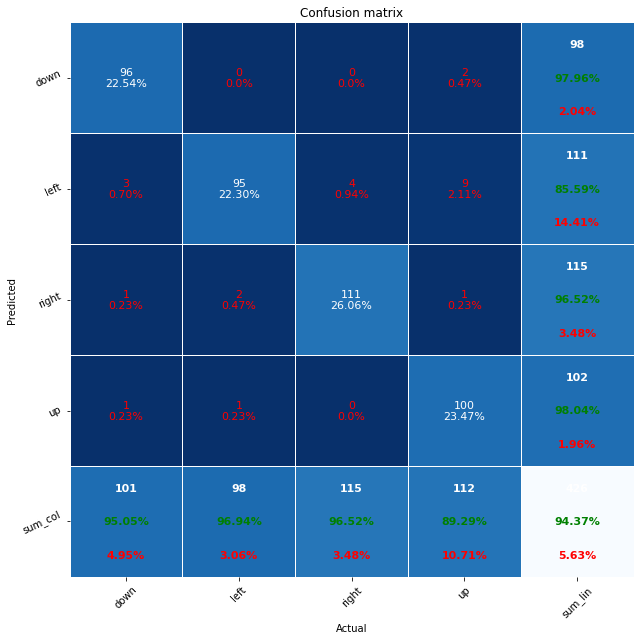

In [3]:
if __name__ == "__main__":
    model, history = main()

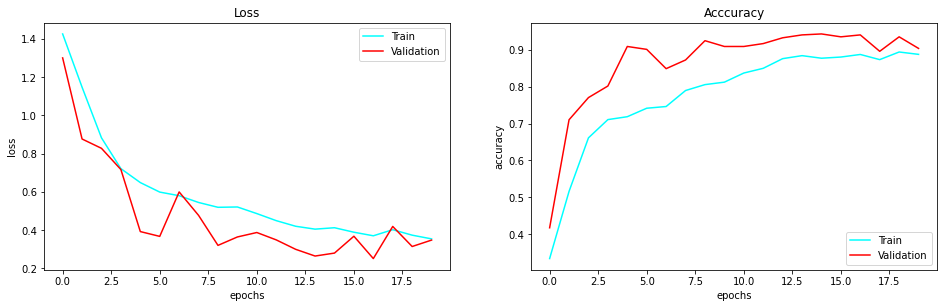

In [7]:

plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], color='cyan')
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], color='cyan')
plt.plot(history.history['val_accuracy'], color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acccuracy')
plt.legend(['Train', 'Validation'], loc='lower right')


plt.subplots_adjust(wspace=0.2)




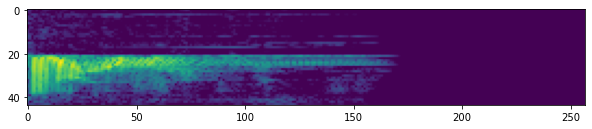

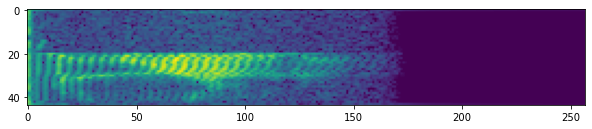

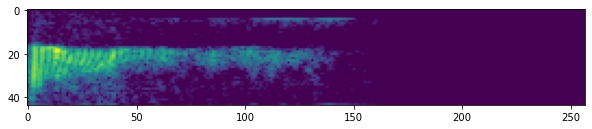

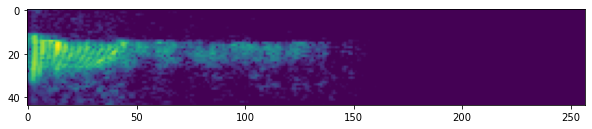

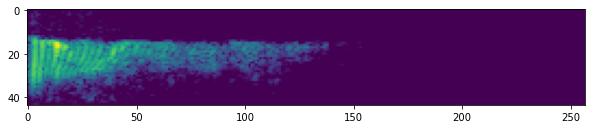

In [17]:
X, y = load_dataset(DATA_PATH)
for i in range(5):
    plt.figure(figsize=(10,2))
    plt.imshow(X[i])
    plt.show()